# MDSF 2018 - La suite - My solution

## First analysis and Feature Engineering

In [1]:
import io, math, requests
import pandas as pd
import operator
import numpy as np
import os
import time
from sklearn.metrics import roc_curve, auc, log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,KFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from hyperopt import hp,fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

In [2]:
path_X_train = "X_train.csv"
path_X_test = "X_test.csv"
path_test = "_test.csv"
X_train = pd.read_csv("X_train.csv", index_col=0, error_bad_lines=False)
test = pd.read_csv("X_test.csv", index_col=0, error_bad_lines=False)
y_train = pd.read_csv("y_train.csv", index_col=0)

train = X_train
train['y'] = y_train
n = len(train)

Skipping line 2168: expected 31 fields, saw 33
Skipping line 4822: expected 31 fields, saw 37
Skipping line 4859: expected 31 fields, saw 37
Skipping line 7342: expected 31 fields, saw 37



In [3]:
X_train.describe(include='all')

,nb_images,longueur_image,largeur_image,url_image,description_produit,taille,matiere,age,garantie,annee,...,poids,prix,categorie,sous_categorie_1,sous_categorie_2,sous_categorie_3,sous_categorie_4,nom_produit,nom_magasin,y
count,8880.000000,8823.000000,8823.000000,8823,8880,2414,3947,120,101,1.497000e+03,...,8.878000e+03,8880.000000,8879,7292,3620,927,70,8064,8880,8880.000000
unique,NaN,NaN,NaN,8775,8836,33,1722,18,2,NaN,...,NaN,NaN,11,169,145,124,37,7921,46,NaN
top,NaN,NaN,NaN,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Relié, 48 pages, couverture usagée",38,Coton,4a,6 mois,NaN,...,NaN,NaN,mode,mode,label selection,les coups de coeur des vendeurs,les coups de coeur des vendeurs,carte postale,Emmaüs Lyon,NaN
freq,NaN,NaN,NaN,4,6,402,144,14,100,NaN,...,NaN,NaN,2982,511,1132,65,7,6,895,NaN
mean,3.633446,1807.821263,1801.773433,NaN,NaN,NaN,NaN,NaN,NaN,1.481011e+04,...,7.794864e+03,21.503309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.991667
std,2.048567,1025.250717,1101.208725,NaN,NaN,NaN,NaN,NaN,NaN,4.962370e+05,...,8.220132e+04,44.024320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.820628
min,0.000000,58.000000,64.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,...,1.000000e-01,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,2.000000,1000.000000,970.500000,NaN,NaN,NaN,NaN,NaN,NaN,1.979000e+03,...,2.520000e+02,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,3.000000,1536.000000,1536.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.998000e+03,...,5.000000e+02,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,5.000000,2448.000000,2448.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.007000e+03,...,1.000000e+03,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


A clue was given during the challenge: consider the length of the description as a feature. Even if logically there was not so much to hope from considering the length of several other categorical variables, I also did it for them. 
I also converted categorical variables that actually had an order (like size of clothes) to make them ordered floating points.

In [4]:
for data in [train, test]:
    data['longueur_mag'] = map(lambda s: len(s.split()), data['nom_magasin'])
    data['longueur_editions'] = map(lambda s: len(s.split()) if type(s)!=float else 0, data['editions'])
    data['longueur_marque'] = map(lambda s: len(s.split()) if type(s)!=float else 0, data['marque'])
    data['longueur_auteur'] = map(lambda s: len(s.split()) if type(s)!=float else 0, data['auteur'])
    data['longueur_desc'] = map(lambda s: len(s.split()), data['description_produit'])
    data['garantie_num'] = data['garantie'].map({'3 mois':3, '6 mois':6, np.nan:0}).astype(int)
    data['etat_num'] = data['etat'].map({"en l'\xc3\xa9tat":-2, 'reconditionn\xc3\xa9':-1, np.nan:np.nan, 'bon \xc3\xa9tat':1, "comme neuf":2, "neuf":3}).astype(float)
    data['etat_presence']=data['etat_num'].map(lambda s: 0 if np.isnan(s) else 1)
    ages_possibles = list(set(data.age))
    def convert2age(s):
        if type(s)==float: return np.nan
        if s=="Naissance":return 0
        unites = 1 if s[-1]=='m' else 12
        return int(s[:-1])*unites
    data['age_num'] = data['age'].map(convert2age).astype(float)
    data['age_presence']=data['age_num'].map(lambda s: 0 if np.isnan(s) else 1)
    def convertTailleChiffre(s):
        try: a = int(s);return a
        except: return np.nan     
    def convertTailleT(s):
        try: assert(s[0]=='T');return int(s[1])
        except: return np.nan
    data['taille_chiffre'] = data['taille'].map(convertTailleChiffre).astype(float)
    data['taille_T'] = data['taille'].map(convertTailleT).astype(float)
    data['taille_SML'] = data['taille'].map({'XS':-2, 'S':-1, 'M':0, 'L':1, 'XL':2, 'XXL':3, 'XXXL':4}).astype(float)
    data['taille_presence'] = data.apply(lambda s: 0 if np.isnan(s['taille_chiffre']) and np.isnan(s['taille_T']) and np.isnan(s['taille_SML']) else 1, axis = 1)
    

Then I distinguished between numerical and categorical features. The 3 last categorical variables ('url_image', 'description_produit','nom_produit') had actually many levels, because it is unique by product. Actually a priori there was no reason to take them into account since a level which is in train data was almost never in test data, and almost only one time in train data, leaving no chance in the future cross-validation for a prediction power. However, surprisingly, it did had an impact to take them into account. The reason is that when you do LabelEncoding with Scikit Learn library, it uses behind the function numpy.unique which begins by sorting the array before returning the unique elements. So finally the levels were sorted in alphabetical order, which actually had a sense. For example, regarding the names of the products, you had the products with a word beginning by "Echarpe" that were next one to the other, or "statuette", "lot", "appareil" even if what followed each of these words was different for each product, so a decision tree-based method was able to bring something.  
I did the test of doing a random permutation of the label encodings to see how it impacted prediction and it confirmed this analysis (log-loss increased by more than 0.02). You can still exploit that to improve the way these categories are taken into account.

In [5]:
features = [a for a in  list(train.columns) if a[0]!='y']

feat_num = ['nb_images', 'longueur_image', 'largeur_image',  'annee', 'largeur_produit',
            'hauteur_produit','poids', 'prix', 'longueur_produit', 'pointure',
            'longueur_mag','longueur_editions', 'longueur_marque', 'longueur_auteur',
            'garantie_num', 'etat_num', 'age_num','taille_chiffre','taille_T', 'taille_SML',
            'taille_presence', 'age_presence', 'etat_presence']
feat_cat =  ['matiere', 'couleur',
             'wifi', 'vintage', 'marque', 'auteur', 'editions',
             'categorie', 'sous_categorie_1', 'sous_categorie_2', 'sous_categorie_3', 
             'sous_categorie_4', 'nom_magasin']
feat_cat += ['url_image', 'description_produit','nom_produit']

features = feat_num + feat_cat


Treating NaNs in a very classic way : 

In [6]:
all_data = pd.concat((train, test), sort = False)
for p in feat_num:
    median = all_data[p].median()
    all_data[p] = all_data[p].fillna(median)
    train[p] = train[p].fillna(median)
    test[p] = test[p].fillna(median)

for p in feat_cat:
    train[p] = train[p].fillna('missing')
    test[p] = test[p].fillna('missing')

Examining correlations :

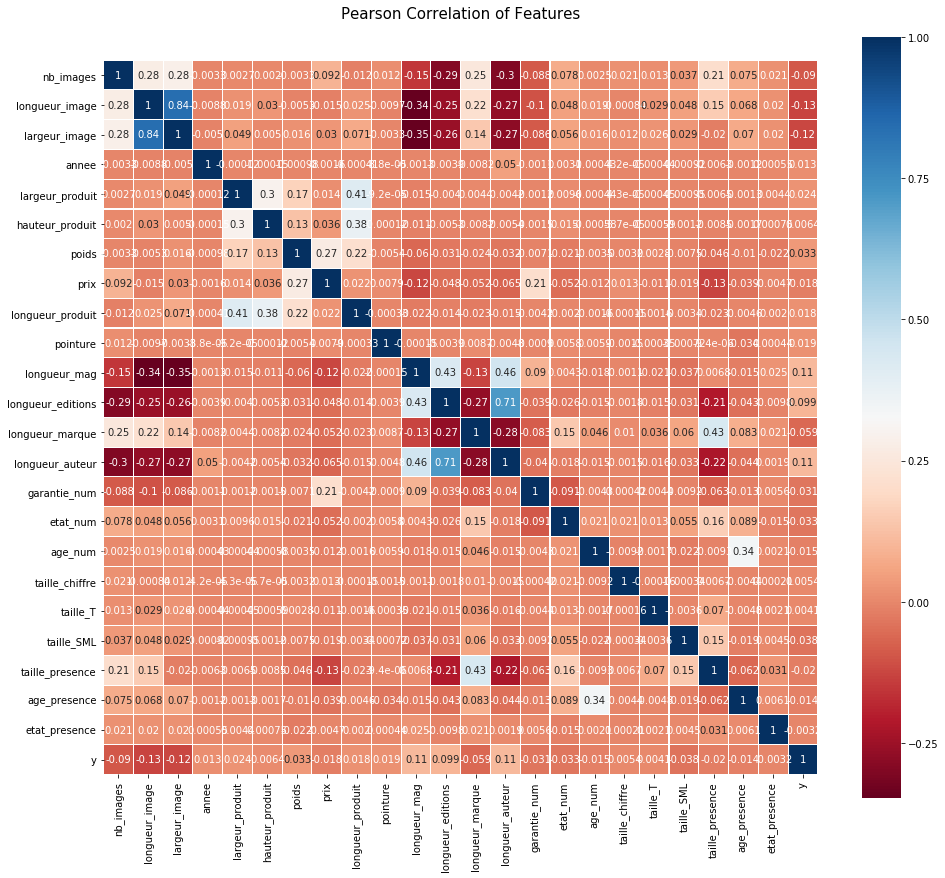

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(16,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train[feat_num + ['y']].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

Then we examine how are distributed the levels for each categorical variable.

In [8]:
for c in feat_cat:
    ct = Counter(list(all_data[c]))
    print "CATEGORY : %s"%c
    print "number unique= %d"%len(ct.most_common(100000))
    print ct.most_common(5)
    print "\n"
    

CATEGORY : matiere
number unique= 2175
[(nan, 6588), ('Coton', 202), ('Cuir', 142), ('100% coton ', 119), ('cuir', 101)]


CATEGORY : couleur
number unique= 19
[(nan, 4778), ('Multicolore', 1425), ('Noir', 1342), ('Marron', 753), ('Bleu', 639)]


CATEGORY : wifi
number unique= 3
[(nan, 11739), (True, 78), (False, 23)]


CATEGORY : vintage
number unique= 3
[(False, 5082), (nan, 4030), (True, 2728)]


CATEGORY : marque
number unique= 3330
[(nan, 6076), ('tmp', 120), ('non renseign\xc3\xa9e ', 70), ('ESPRIT', 65), ('ZARA', 62)]


CATEGORY : auteur
number unique= 1304
[(nan, 9957), ('Herg\xc3\xa9', 29), ('Collectif', 29), ('Danielle Steel', 24), ('Guillaume Musso', 22)]


CATEGORY : editions
number unique= 801
[(nan, 9930), ('Pocket', 110), ('Le Livre De Poche', 106), ('Casterman', 53), ("J'Ai Lu", 52)]


CATEGORY : categorie
number unique= 12
[('mode', 3964), ('mobilier - deco', 2452), ('librairie', 1958), ('label selection', 1213), ('loisirs', 1117)]


CATEGORY : sous_categorie_1
number 

Now an important part of the code :
For the binary categorical variables, I transformed them into 1 and -1, and for missing values, I took a logivcal value between -1 and 1. (Actually because I used a decision-tree based model, the value between -1 and 1 was finally not important).
In order to deal with the other categorical variables, I did following : a categorical value which is frequent must be really taken into account (i.e.lonely) , i.e. not with Label Encoding, and scarce categorical values can be used together with Label Encoding.
For the threshold to use to decide what is a frequent categorical value, I tested different values examining the results given by a Random Forest in prediction [and not directly the Gradient Boosting because it took too times to optimize meta-parameters]. I finally used a thresold of 75 but results were not so much different for lower thresholds (but a threshold of 75 allowed me to have less features)

In [9]:
train['train'] = True
test['train'] = False
all_data = pd.concat((train, test), axis = 0, sort = False)

feat_cat_common = []
feat_cat_labelEncoded = []
threshold = 75
p = 'matiere'
for p in feat_cat:
    print p
    ct = Counter(all_data[p])
    if len(ct.most_common(100)) == 2 or (len(ct.most_common(100))==3 and 'missing' in [a[0] for a in ct.most_common(100)]):
        commons = [q for q in ct.most_common(3) if  q[0] != 'missing']
        a, ct_a  = commons[0]
        b, ct_b = commons[1]
        moy = float(ct_a - ct_b)/float(ct_a+ct_b)
        train[p + '_'+str(a)] = train[p].map({a:1, b:-1, 'missing': moy})
        test[p+'_'+str(a)] = test[p].map({a:1, b:-1, 'missing': moy})
        feat_num.append(p+'_'+str(a))
    else:
        commons = [a for a in ct.most_common(100) if a[1]>=threshold]
        words_commons = [a[0] for a in commons]
        all_data[p+'_common'] = all_data[p].map(lambda s: s if s in words_commons else 'rare')
        feat_cat_common.append(p+'_common')
        all_data[p + '_rare'] = all_data[p].map(lambda s: s if s not in words_commons else 'not_rare')
        le = LabelEncoder()
        le.fit(all_data[p+'_rare'])
        for data in [train, test]:
            data[p +  '_rare'] =  data[p].map(lambda s: s if s not in words_commons else 'not_rare')
            data[p+ '_labelEncoded'] = le.transform(data[p+ '_rare'])
        feat_cat_labelEncoded.append(p+'_labelEncoded')

matiere
couleur
wifi
vintage
marque
auteur
editions
categorie
sous_categorie_1
sous_categorie_2
sous_categorie_3
sous_categorie_4
nom_magasin
url_image
description_produit
nom_produit


Here we use get_dummies to dot the OneHotEncoding for the frequent categories. And we obtain our final features to use.

In [10]:
all_dummies = pd.get_dummies(all_data[feat_cat_common + ['train']], columns = feat_cat_common)

feat_dummies = list(all_dummies.columns)
feat_dummies.remove('train')
train_only_cats_dummies = all_dummies[all_dummies.train]
test_only_cats_dummies = all_dummies[all_dummies.train==False]

train = pd.concat((train, train_only_cats_dummies), axis = 1)
test = pd.concat((test, test_only_cats_dummies), axis = 1)

features_used = feat_num+feat_cat_labelEncoded + feat_dummies
features_used = [a for i, a in enumerate(features_used) if a not in features_used[:i]]

train[features_used].head()

,nb_images,longueur_image,largeur_image,annee,largeur_produit,hauteur_produit,poids,prix,longueur_produit,pointure,...,nom_magasin_common_Label Emmaus Angers,nom_magasin_common_Label Emmaüs Chambéry,nom_magasin_common_Label Emmaüs de Grenoble,nom_magasin_common_Le Léopard,nom_magasin_common_Tri d'Union - la boutique en ligne,nom_magasin_common_rare,url_image_common_rare,description_produit_common_rare,nom_produit_common_missing,nom_produit_common_rare
id,,,,,,,,,,,,,,,,,,,,,
0,3,3458.0,2552.0,1998.0,40.0,60.0,200.0,4.5,50.0,39.0,...,0,0,0,0,0,0,1,1,0,1
1,2,2486.0,2254.0,1998.0,40.0,60.0,1000.0,15.0,50.0,39.0,...,0,0,0,0,0,1,1,1,0,1
2,3,1536.0,1536.0,1998.0,40.0,60.0,360.0,16.0,50.0,39.0,...,0,1,0,0,0,0,1,1,1,0
3,2,1100.0,1100.0,1998.0,40.0,60.0,520.0,24.0,50.0,39.0,...,0,0,0,0,0,0,1,1,0,1
4,2,450.0,450.0,1998.0,40.0,60.0,300.0,139.0,50.0,39.0,...,0,0,0,0,0,0,1,1,0,1


## Random Forest

Then Random Forest with cross-validation was used : it is quicker to test the relevance of all the feature engineering than Gradient Boosting, and you already obtain very good results. I generally iterated ~3 times Cross-Validation to find the best max_depth and max_features, considering at the beginning larges values (like 'max_depth' : [5,12,20], 'max_features': [0.1,0.4,0.8]) and reducing the extent of the values to search (for example finally 'max_depth' : [18,19,20], 'max_features': [0.22,0.25,0.28]). The number of trees can be chosen not too big to go faster, and if you finally use Random Forest you can increase it before submission. The criterion can also be optimized between gini and entropy.

In [11]:
n_folds = 5
n_jobs = 7
rf = RandomForestClassifier(random_state = 4)
grid = {'max_depth' : [20,22], 'max_features': [0.3,0.35], 'n_estimators' : [300], 'criterion' : ['gini', 'entropy']}

cve = GridSearchCV(estimator = rf, param_grid = grid, scoring ='neg_log_loss' ,
                   cv = n_folds, n_jobs = n_jobs, verbose = 1)

t0 = time.time()
cve.fit(train[features_used],train['y'])
print time.time() - t0
rf = cve.best_estimator_
grid_scores = cve.grid_scores_
print grid_scores
print rf
print cve.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:  2.8min finished


181.221292973
[mean: -0.91067, std: 0.01469, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 20}, mean: -0.91393, std: 0.01255, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 20}, mean: -0.91539, std: 0.01255, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 22}, mean: -0.90970, std: 0.01379, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'gini', 'max_depth': 22}, mean: -0.91386, std: 0.01189, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 20}, mean: -0.91484, std: 0.01259, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 20}, mean: -0.91097, std: 0.01330, params: {'max_features': 0.3, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 22}, mean: -0.91207, std: 0.01329, params: {'max_features': 0.35, 'n_estimators': 300, 'criterion': 'entropy', 'max_depth': 22}]
RandomFor

/home/jbotbol/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Plotting results of each Cross-validation like following is a good way to quickly see the direction to follow. In the above example, I didn't test many combinations, but when you do it, it is still more useful.

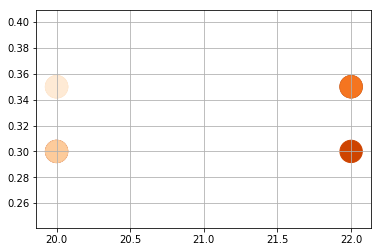

In [12]:
depths = [a[0]['max_depth'] for a in grid_scores]
max_features = [a[0]['max_features'] for a in grid_scores]
y = [np.exp(a[1]) for a in grid_scores]

plt.scatter(depths, max_features, c=y, s=500, cmap = 'Oranges')
plt.grid()
plt.show()

Then the final submission if you use Random Forest.

In [13]:
params = rf.get_params()
rf = RandomForestClassifier(n_estimators = 2000, max_depth = params['max_depth'],
                            max_features = params['max_features'], 
                            criterion = params['criterion'], n_jobs = -1)
print rf
rf.fit(train[features_used],train['y'])
y_test_pred = rf.predict_proba(test[features_used])
#submit

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=22, max_features=0.35, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Gradient Boosting

For Gradient Boosting, I used xgboost with 5 folds, considering for each try of hyperparameters the average log-loss score. To optimize them, I used hyperopt which is supposed to do a smart research of hyperparameters starting with the given distributions (prior dist.) and taking into account histories of scores to go to good direction updating the posterior dist. after each try (I didn't take the time to dive into the details, but it should be better than Random Search :-)). 

Early stopping allows the model to stop adding trees when it stops improving the score on validation set after a few iterations (that you can set). Then you find the optimal number of trees to choose for the final model trained on all the data.

Finally, because a learning rate of 0.01 is low, and training is long, you can begin with a learning rate of 0.1, with a large distribution for the hyperparameters, and then do a second pass where you shorten the dist. and use a learning rate of 0.01 (which gives better performance). Here I commented examples of distributions, and wrote the final hyperparameters I used.

In [14]:
n_folds =  5
kf = KFold(n_folds, shuffle = True) 
indices_kf = [(p[0], p[1]) for p in kf.split(range(n))]
def loss(est, X, y):
    preds = est.predict_proba(np.array(X))
    return log_loss(y, preds)

early_stopping_around = 50
n_jobs = 7
nb_evaluations_hyperopt = 1
gb = XGBClassifier()


dico_res_gb = dict()
def scoreGB(params):
    print "params : %s"%str(params)
    for q in params:
        v =  params[q]
        if type(v)==float and int(v)==v:
            params[q] = int(v)
    gb  =  XGBClassifier(**params)
    scores_test_gb = []; scores_train_gb= []; lengths = []
    for indices_train, indices_test in indices_kf:
        eval_set = [(np.array(train.loc[indices_train,features_used]),np.array(train.loc[indices_train, 'y'])),
                (np.array(train.loc[indices_test,features_used]),np.array(train.loc[indices_test, 'y']))]
        gb.fit(np.array(train.loc[indices_train,features_used]),np.array(train.loc[indices_train, 'y']),
                eval_metric=['mlogloss'], eval_set = eval_set, 
                early_stopping_rounds= early_stopping_around, verbose=False)
        score_train_gb = loss(gb,train.loc[indices_train,features_used],train.loc[indices_train, 'y'] )
        score_test_gb = loss(gb,train.loc[indices_test,features_used],(train.loc[indices_test, 'y']) )
        scores_train_gb.append(score_train_gb)
        scores_test_gb.append(score_test_gb)
        length = len(gb.evals_result()['validation_1']['mlogloss'])
        lengths.append(length)
        print " Score on Train Set : %.4f, Score on Test Set : %.4f"%(score_train_gb, score_test_gb)
    length_mean = int(np.mean(lengths))
    score_test_avg_gb = np.mean(scores_test_gb)
    dico_res_gb[tuple(params.items() + [('n_estimators',length_mean - early_stopping_around)])] = score_test_avg_gb
    
    print "AVG TEST Score : %.4f"%score_test_avg_gb
    return {"loss": score_test_avg_gb, "status": STATUS_OK}


def optimizeGB():
#    space = {
#            'objective':'multi:softprob',
#             'n_estimators' : 2000,
#             'learning_rate' : 0.01,
#             'max_depth' : hp.quniform('max_depth', 3, 18, 1),
#             'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
#             'subsample' : hp.quniform('subsample', 0.6, 1, 0.05),
#             'gamma' : hp.quniform('gamma', 0,0.1,0.01),
#             'colsample_bytree' : hp.quniform('colsample_bytree', 0.2, 0.25, 0.01),
#             'silent' : True,
#             'nthread' : n_jobs
#             }
    space = {
            'objective':'multi:softprob',
             'n_estimators' : 2000,
             'learning_rate' : 0.01,
             'max_depth' : 15,
             'min_child_weight' : 6.15,
             'subsample' : 0.95,
             'gamma' : 0.073,
             'colsample_bytree' :0.23,
             'silent' : True,
             'nthread' : n_jobs
             }

    best = fmin(scoreGB, space, algo=tpe.suggest, max_evals=nb_evaluations_hyperopt)

    print best

In [15]:
t0 = time.time()
optimizeGB()
print time.time() - t0
best_ones = sorted(dico_res_gb.items(), key=operator.itemgetter(1), reverse = False)[:5]
print best_ones
best_pars = best_ones[0]
best_score = best_pars[1]
best_pars = best_pars[0]
best_pars = dict(best_pars)


params : {'colsample_bytree': 0.23, 'silent': True, 'learning_rate': 0.01, 'nthread': 7, 'min_child_weight': 6.15, 'n_estimators': 2000, 'subsample': 0.95, 'objective': 'multi:softprob', 'max_depth': 15, 'gamma': 0.073}
 Score on Train Set : 0.4918, Score on Test Set : 0.9186
 Score on Train Set : 0.4427, Score on Test Set : 0.8954
 Score on Train Set : 0.4731, Score on Test Set : 0.8942
 Score on Train Set : 0.4807, Score on Test Set : 0.9198
 Score on Train Set : 0.4418, Score on Test Set : 0.9211
AVG TEST Score : 0.9098
{}
178.613896132
[((('colsample_bytree', 0.23), ('silent', True), ('learning_rate', 0.01), ('nthread', 7), ('min_child_weight', 6.15), ('n_estimators', 2000), ('subsample', 0.95), ('objective', 'multi:softprob'), ('max_depth', 15), ('gamma', 0.073), ('n_estimators', 1003)), 0.90983528897967525)]


In [16]:
print "BEST PARAMS :"
print best_pars
print "BEST SCORE :%.5f"%best_score
gb = XGBClassifier(**best_pars)
gb.fit(train[features_used],train['y'],eval_metric=['mlogloss'], verbose=False)

y_test_pred = gb.predict_proba(test[features_used])
#submit

BEST PARAMS :
{'colsample_bytree': 0.23, 'silent': True, 'learning_rate': 0.01, 'nthread': 7, 'min_child_weight': 6.15, 'n_estimators': 1003, 'subsample': 0.95, 'objective': 'multi:softprob', 'max_depth': 15, 'gamma': 0.073}
BEST SCORE :0.90984


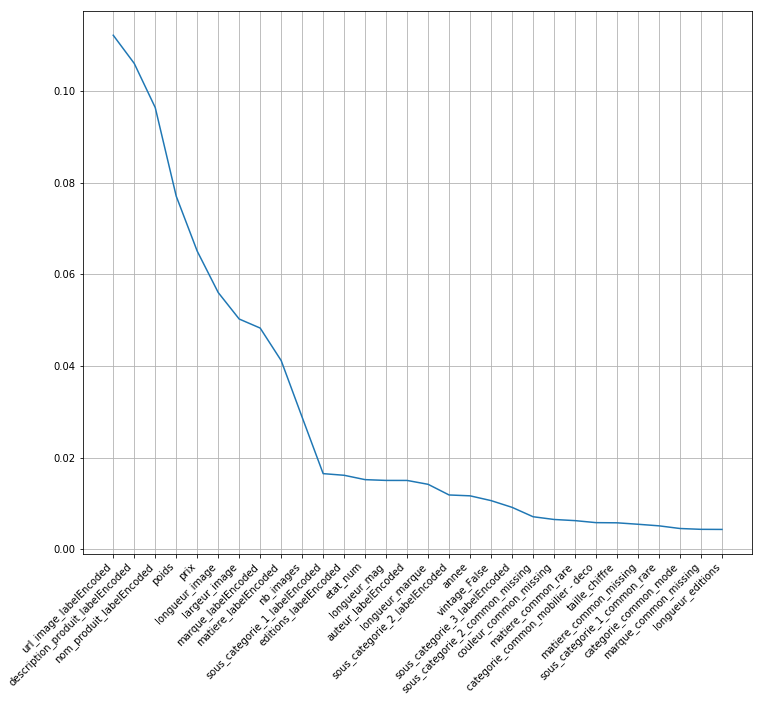

In [17]:
feature_importances = gb.feature_importances_
coefs = {k[0]:k[1] for k in zip(features_used, feature_importances)}
sorted_coefs = sorted(coefs.items(), key=operator.itemgetter(1), reverse = True)
top = 30
plt.plot(range(len(sorted_coefs[:top])), [a[1] for a in sorted_coefs[:top]])
plt.xticks(range(len(sorted_coefs[:top])), 
           [a[0].decode('utf-8') for a in sorted_coefs[:top]], 
           rotation =45,
           ha ='right')
plt.grid()
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 10)

When you train the model on the entire training set, you obtain a lower log-loss, and that's what finally allowed to cross just below 0.9.
To conclude, there are things to do to still improve this model, especially with the scarce variables.